In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import numpy as np
import gc
import pickle

In [42]:
base_path = '/scratch/ashahban'

def base_dir(file_name):
  return os.path.join(base_path, file_name)

In [43]:
df = pd.read_csv(base_dir('measures_v2.csv'))

In [44]:
df.drop(columns=['torque'], inplace=True)

In [45]:
df['i_s'] = np.sqrt(np.power(df['i_d'], 2) + np.power(df['i_q'], 2))
df['u_s'] = np.sqrt(np.power(df['u_d'], 2) + np.power(df['u_q'], 2))
df['power'] = df['i_s'] * df['u_s']
df['j1'] = df['i_s'] * df['motor_speed']
df['j2'] = df['power'] * df['motor_speed']

In [46]:
cols = df.columns.to_list()
target_cols = ['stator_tooth', 'stator_winding', 'stator_yoke', 'pm']
input_cols = [col for col in cols if col not in target_cols]
input_cols.remove('profile_id')
cols =  input_cols + target_cols + ['profile_id']
df = df[cols]
n_features = len(input_cols)
df.head()

,u_q,coolant,u_d,motor_speed,i_d,i_q,ambient,i_s,u_s,power,j1,j2,stator_tooth,stator_winding,stator_yoke,pm,profile_id
0,-0.450682,18.805172,-0.350055,0.002866,0.004419,0.000328,19.850691,0.004431,0.570659,0.002529,1.269819e-05,7.246341e-06,18.293219,19.086670,18.316547,24.554214,17
1,-0.325737,18.818571,-0.305803,0.000257,0.000606,-0.000785,19.850672,0.000992,0.446789,0.000443,2.547010e-07,1.137975e-07,18.294807,19.092390,18.314955,24.538078,17
2,-0.440864,18.828770,-0.372503,0.002355,0.001290,0.000386,19.850657,0.001346,0.577165,0.000777,3.170383e-06,1.829834e-06,18.294094,19.089380,18.326307,24.544693,17
3,-0.327026,18.835567,-0.316199,0.006105,0.000026,0.002046,19.850647,0.002046,0.454893,0.000931,1.248905e-05,5.681180e-06,18.292542,19.083031,18.330833,24.554018,17
4,-0.471150,18.857033,-0.332272,0.003133,-0.064317,0.037184,19.850639,0.074292,0.576530,0.042832,2.327433e-04,1.341835e-04,18.291428,19.082525,18.326662,24.565397,17


In [47]:
zero_padding = 10000
chunks = []

for pid in df.profile_id.unique():
  prof_df = df[df['profile_id'] == pid]
  profile_first_index = prof_df.index[0]
  profile_last_index = prof_df.index[-1]
  zeros = np.zeros((zero_padding, df.shape[1]))
  zeros[:, -1] = pid
  chunks.append(zeros)
  chunks.append(df.iloc[profile_first_index:profile_last_index+1, :])

zero_padded_df = pd.DataFrame(np.vstack(chunks), columns=df.columns)

In [48]:
ewma_spans = [500, 2200, 6000, 9000]
ewmstd_spans = [500, 2200, 6000, 9000]
ma_spans = []
f_dfs = []
for span in ewma_spans:
  f_dfs.append(zero_padded_df.groupby('profile_id').ewm(span=span).mean()[input_cols].add_prefix(f'ewma{span}_'))

for span in ewmstd_spans:
  f_dfs.append(zero_padded_df.groupby('profile_id').ewm(span=span).std()[input_cols].add_prefix(f'ewmstd{span}_'))

for span in ma_spans:
  f_dfs.append(zero_padded_df.groupby('profile_id').rolling(span,1).mean()[input_cols].add_prefix(f'ma{span}_'))

f_dfs.append(zero_padded_df.groupby('profile_id').rolling(1,1).mean())
fdf = pd.concat(f_dfs, axis=1)#.drop(columns=['profile_id'])
fdf = fdf.reset_index().drop(columns=['level_1'])

del f_dfs
gc.collect()

2159

In [49]:
fdf.drop(fdf[fdf['pm'] == 0].index, axis=0, inplace=True)

In [50]:
fdf

,profile_id,ewma500_u_q,ewma500_coolant,ewma500_u_d,ewma500_motor_speed,ewma500_i_d,ewma500_i_q,ewma500_ambient,ewma500_i_s,ewma500_u_s,...,ambient,i_s,u_s,power,j1,j2,stator_tooth,stator_winding,stator_yoke,pm
10000,2.0,0.019648,0.062744,0.000204,0.399060,-1.535420e-06,8.833468e-07,0.079820,0.000002,0.019649,...,19.995035,0.000444,4.921979,0.002184,0.044358,0.218327,18.889385,19.729197,18.395088,23.153740
10001,2.0,0.039324,0.125930,0.000502,0.796740,-9.527263e-06,4.417545e-06,0.159159,0.000011,0.039327,...,19.954098,0.002191,4.949102,0.010842,0.219113,1.084412,18.895809,19.737572,18.376493,23.153469
10002,2.0,0.058893,0.189270,0.000754,1.192761,-8.864981e-06,4.217495e-06,0.238064,0.000011,0.058898,...,19.924765,0.000163,4.941887,0.000805,0.016291,0.080510,18.902767,19.740677,18.371748,23.147993
10003,2.0,0.078304,0.252927,0.001058,1.587122,-2.979288e-06,-3.229799e-07,0.316569,0.000018,0.078311,...,19.903748,0.001853,4.921776,0.009118,0.185214,0.911581,18.908100,19.727468,18.375002,23.135658
10004,2.0,0.097649,0.316449,0.001391,1.980081,-2.433517e-07,1.345932e-05,0.394701,0.000032,0.097659,...,19.888687,0.003519,4.925073,0.017331,0.351976,1.733508,18.876144,19.730543,18.378679,23.137959
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020811,81.0,-0.627476,85.547111,-0.710750,-0.000127,-2.000631e+00,1.097237e+00,24.841076,2.281766,0.949210,...,24.904142,2.280765,0.944289,2.153702,-0.003253,-0.003072,79.454299,81.572526,80.292928,58.622086
2020812,81.0,-0.627525,85.547424,-0.711069,-0.000122,-2.000632e+00,1.097240e+00,24.841330,2.281768,0.949481,...,24.904809,2.282185,1.017020,2.321027,0.002490,0.002532,79.456187,81.556430,80.322906,58.626926
2020813,81.0,-0.627604,85.547694,-0.710939,-0.000120,-2.000629e+00,1.097239e+00,24.841588,2.281765,0.949433,...,24.905987,2.281188,0.937658,2.138974,0.000761,0.000714,79.454690,81.541998,80.334215,58.631781
2020814,81.0,-0.627603,85.547966,-0.711344,-0.000103,-2.000631e+00,1.097238e+00,24.841830,2.281766,0.949741,...,24.902054,2.282064,1.026551,2.342654,0.009232,0.009477,79.453742,81.518069,80.324450,58.634744


In [51]:
fdf.shape[0] == df.shape[0]

True

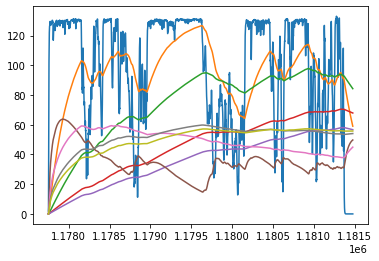

In [52]:
profile = fdf[fdf['profile_id'] == 52]

plt.plot(profile['u_s'])
for span in ewma_spans:
  plt.plot(profile[f'ewma{span}_u_s'])
for span in ewmstd_spans:
  plt.plot(profile[f'ewmstd{span}_u_s'])
for span in ma_spans:
  plt.plot(profile[f'ma{span}_u_s'])

In [53]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

def preprocess_series(data, train=False):
  if train:
    scaler.fit(data)
  
  return scaler.transform(data)
  
def invTransform(data):
    # return data
    dummy = np.zeros((len(data), scaler.n_features_in_))
    dummy[:, -4:] = data
    return scaler.inverse_transform(dummy)[:, -4:]
    

In [54]:
train_data = fdf[~fdf.profile_id.isin([65, 72, 58])].drop(columns=['profile_id']).to_numpy()
val_data = fdf[fdf.profile_id.isin([58])].drop(columns=['profile_id']).to_numpy()
test1_data = fdf[fdf.profile_id.isin([65])].drop(columns=['profile_id']).to_numpy()
test2_data = fdf[fdf.profile_id.isin([72])].drop(columns=['profile_id']).to_numpy()

In [55]:
train_data = preprocess_series(train_data, train=True)
val_data = preprocess_series(val_data, train=False)
test1_data = preprocess_series(test1_data, train=False)
test2_data = preprocess_series(test2_data, train=False)

In [56]:
from keras.preprocessing.sequence import TimeseriesGenerator

n_steps = 128
batch_size = 1024

train_generator = TimeseriesGenerator(train_data[:, :-4], train_data[:, -4:], length=n_steps, batch_size=batch_size, shuffle=True)
val_generator = TimeseriesGenerator(val_data[:, :-4], val_data[:, -4:], length=n_steps, batch_size=batch_size)
test1_generator = TimeseriesGenerator(test1_data[:, :-4], test1_data[:, -4:], length=n_steps, batch_size=batch_size)
test2_generator = TimeseriesGenerator(test2_data[:, :-4], test2_data[:, -4:], length=n_steps, batch_size=batch_size)


In [57]:
y_test1 = invTransform(test1_generator.targets)[128:]
y_test2 = invTransform(test2_generator.targets)[128:]
y_val = invTransform(val_generator.targets)[128:]

In [58]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def check_and_save_model(model, history):
    outdir = f'results/{model.name}_{np.random.randint(1000)}'
    os.mkdir(outdir)
    
    test1_pred = invTransform(model.predict(test1_generator))
    test2_pred = invTransform(model.predict(test2_generator))
    val_pred = invTransform(model.predict(val_generator))
    
    with open(f'{outdir}/report.txt', 'w+') as fh:
        fh.write(f'ewma_spans: {str(ewma_spans)}\n')
        fh.write(f'ewmstd_spans: {str(ewmstd_spans)}\n')
        fh.write(f'ma_spans: {str(ma_spans)}\n')
        
        for t, tn in enumerate(target_cols):
            test1_mse = mean_squared_error(y_test1[:,t], test1_pred[:,t])
            test1_mae = mean_absolute_error(y_test1[:,t], test1_pred[:,t])
            test1_r2 = r2_score(y_test1[:,t], test1_pred[:,t])
            test2_mse = mean_squared_error(y_test2[:,t], test2_pred[:,t])
            test2_mae = mean_absolute_error(y_test2[:,t], test2_pred[:,t])
            test2_r2 = r2_score(y_test2[:,t], test2_pred[:,t])
            val_mse = mean_squared_error(y_val[:,t], val_pred[:,t])
            val_mae = mean_absolute_error(y_val[:,t], val_pred[:,t])
            val_r2 = r2_score(y_val[:,t], val_pred[:,t])
            fh.write(f'=== {tn} ===\n')
            fh.write(f'(Test) Profile 65: {test1_mse}\t{test1_mae}\t{test1_r2}\n')
            fh.write(f'(Test) Profile 72: {test2_mse}\t{test2_mae}\t{test2_r2}\n')
            fh.write(f'(Val)  Profile 58: {val_mse}\t{val_mae}\t{val_r2}\n')

        fh.write('\n\n----- Model Summary -----\n\n')

        model.summary(print_fn=lambda x: fh.write(x + '\n'))
    
    with open(f'{outdir}/history.pkl', 'wb+') as fh:
        pickle.dump(history, fh)
        
    model.save(f'{outdir}/model.h5')

#     tf.keras.utils.plot_model(model, to_file=f'{outdir}/model.png', show_shapes=True, show_layer_names=False)
    
    plt.figure()
    plt.title(f'Model MSE')
    plt.plot(history['loss'], color='g', label='Train MSE')
    plt.plot(history['val_loss'], color='b', label='Val MSE')
    plt.xlabel('Epochs')
    plt.ylabel('Mean Squared Error')
    plt.legend()
    plt.savefig(f'{outdir}/Model MSE.png')
    plt.savefig(f'{outdir}/Model MSE.pdf')
    plt.show()
    
    plt.figure()
    plt.title(f'Model MAE')
    plt.plot(history['mae'], color='g', label='Train MAE')
    plt.plot(history['val_mae'], color='b', label='Val MAE')
    plt.xlabel('Epochs')
    plt.ylabel('Mean Absolute Error')
    plt.legend()
    plt.savefig(f'{outdir}/Model MAE.png')
    plt.savefig(f'{outdir}/Model MAE.pdf')
    plt.show()
    
    for t, tn in enumerate(target_cols):
        
        plt.figure()
        plt.title(f'{tn} Temperature Prediction (Profile 65)')
        plt.xlabel('Time step')
        plt.ylabel(f'{tn} Temperature (°C)')
        plt.plot(y_test1[:,t], label='True Value')
        plt.plot(test1_pred[:,t], label='Predicted')
        plt.legend()
        plt.savefig(f'{outdir}/{tn}_profile65.png')
        plt.savefig(f'{outdir}/{tn}_profile65.pdf')


        
        plt.figure()
        plt.title(f'{tn} Temperature Prediction (Profile 72)')
        plt.xlabel('Time step')
        plt.ylabel(f'{tn} Temperature (°C)')
        plt.plot(y_test2[:,t], label='True Value')
        plt.plot(test2_pred[:,t], label='Predicted')
        plt.legend()
        plt.savefig(f'{outdir}/{tn}_profile72.png')
        plt.savefig(f'{outdir}/{tn}_profile72.pdf')


        
        plt.figure()
        plt.title(f'{tn} Temperature Prediction (Profile 58)')
        plt.xlabel('Time step')
        plt.ylabel(f'{tn} Temperature (°C)')
        plt.plot(y_val[:,t], label='True Value')
        plt.plot(val_pred[:,t], label='Predicted')
        plt.legend()
        plt.savefig(f'{outdir}/{tn}_profile58.png')
        plt.savefig(f'{outdir}/{tn}_profile58.pdf')
    
    

In [60]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input
from attention import Attention

n_features = train_data.shape[1] - 4

model = Sequential(name='simple_lstm')
model.add(Input((n_steps, n_features)))

model.add((LSTM(256, activation='tanh', return_sequences=True)))
model.add((LSTM(256, activation='tanh', return_sequences=False)))
model.add(Dense(128, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(4, activation='linear'))
optim=tf.keras.optimizers.Adam(0.001)
model.compile(optimizer=optim, loss='mse', metrics=['mae'])
model.summary()

Model: "simple_lstm"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (None, 128, 256)          373760    
                                                                 
 lstm_13 (LSTM)              (None, 256)               525312    
                                                                 
 dense_18 (Dense)            (None, 128)               32896     
                                                                 
 dense_19 (Dense)            (None, 32)                4128      
                                                                 
 dense_20 (Dense)            (None, 4)                 132       
                                                                 
Total params: 936,228
Trainable params: 936,228
Non-trainable params: 0
_________________________________________________________________


In [61]:
gc.collect()

106799

In [62]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(patience=3, factor=0.2, min_lr=1e-6)
es = tf.keras.callbacks.EarlyStopping(patience=5)
history = model.fit(train_generator, validation_data=val_generator, epochs=30,
          verbose=1, callbacks=[reduce_lr, es])

Epoch 1/30
1213/1213 [==============================] - 56s 44ms/step - loss: 0.0059 - mae: 0.0322 - val_loss: 0.0115 - val_mae: 0.0852 - lr: 0.0010
Epoch 2/30
1213/1213 [==============================] - 53s 44ms/step - loss: 6.7828e-04 - mae: 0.0162 - val_loss: 0.0108 - val_mae: 0.0829 - lr: 0.0010
Epoch 3/30
1213/1213 [==============================] - 54s 44ms/step - loss: 5.9466e-04 - mae: 0.0150 - val_loss: 0.0089 - val_mae: 0.0739 - lr: 0.0010
Epoch 4/30
1213/1213 [==============================] - 53s 44ms/step - loss: 4.9924e-04 - mae: 0.0135 - val_loss: 0.0095 - val_mae: 0.0764 - lr: 0.0010
Epoch 5/30
1213/1213 [==============================] - 54s 44ms/step - loss: 3.9798e-04 - mae: 0.0122 - val_loss: 0.0140 - val_mae: 0.0921 - lr: 0.0010
Epoch 6/30
1213/1213 [==============================] - 54s 44ms/step - loss: 6.6820e-04 - mae: 0.0145 - val_loss: 0.0106 - val_mae: 0.0805 - lr: 0.0010
Epoch 7/30
1213/1213 [==============================] - 54s 44ms/step - loss: 2.1569e-

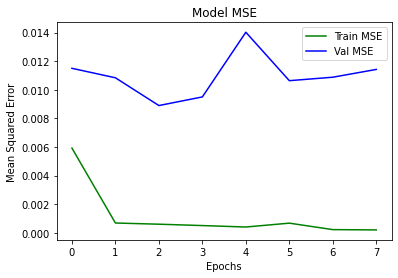

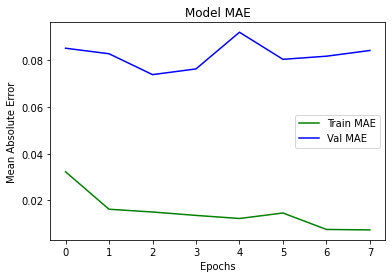

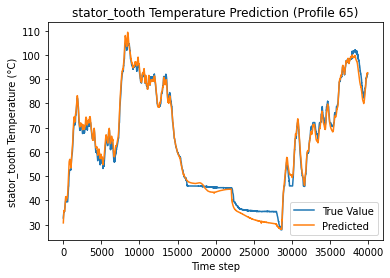

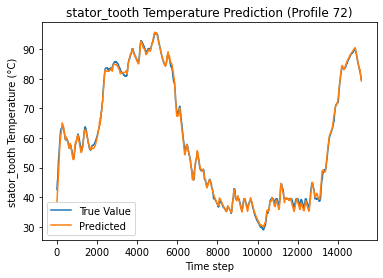

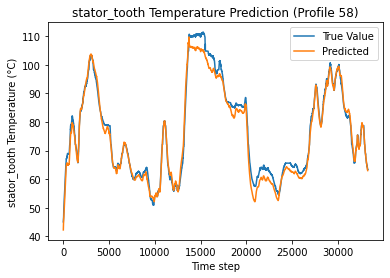

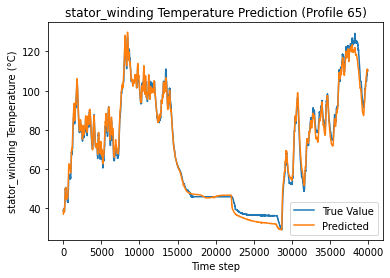

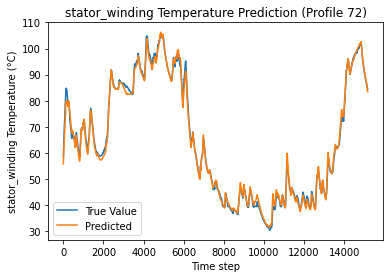

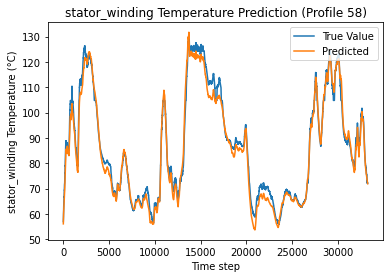

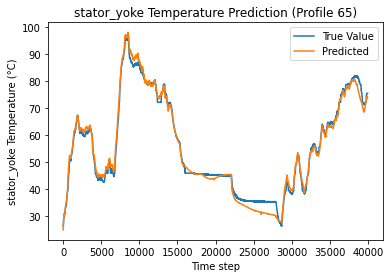

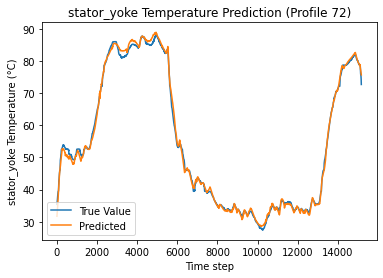

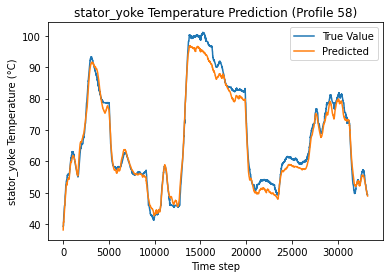

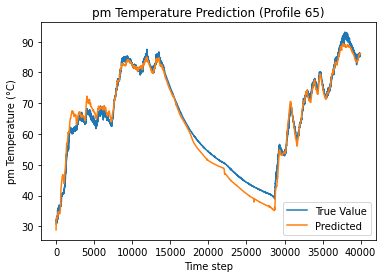

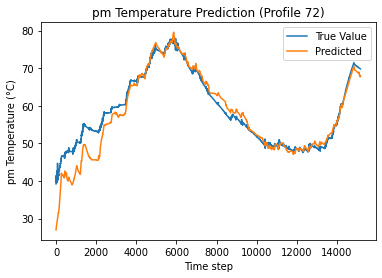

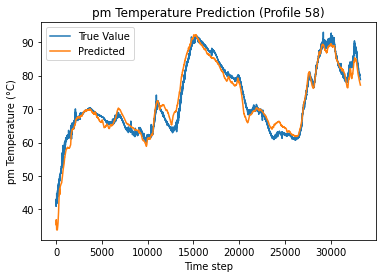

In [63]:
check_and_save_model(model, history.history)